In [569]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import iris
import netCDF4
import datetime
import matplotlib.cm as cm
import itertools
from scipy.spatial import KDTree



In [570]:
site_code_for_comparison = 'NRSYON'

# bottom_depth_greater_than = 25.0
bottom_depth_greater_than = 25.0
surface_depth_shallower_than = 2.0

## Mooring data

data from https://portal.aodn.org.au/search

In [571]:
file = '/Users/ph290/Downloads/IMOS_-_Australian_National_Mooring_Network_ANMN_-_CTD_Profiles.csv'


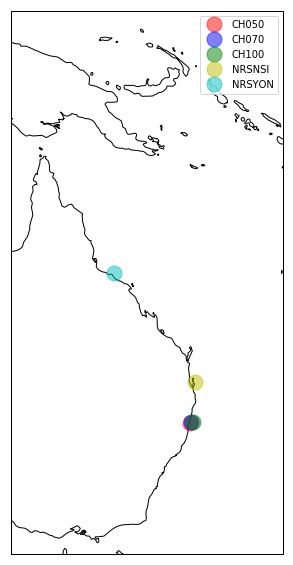

In [572]:
colors = itertools.cycle(["r", "b", "g","y",'c'])

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([140, 160, -40, 0], crs=ccrs.PlateCarree())

for i,site_code_tmp in enumerate(np.unique(df2.site_code)):
    df_tmp = df[(df['site_code'].str.match(site_code_tmp))]
    lat = np.mean(np.unique(df_tmp.LATITUDE))
    lon = np.mean(np.unique(df_tmp.LONGITUDE))
    ax.plot(lon, lat, 'o',color=next(colors),markersize=15, transform=ccrs.PlateCarree(),label=site_code_tmp,alpha=0.5)

plt.legend()
ax.coastlines('50m')
plt.show()

In [573]:
df['datetime'] =pd.to_datetime(df.TIME)

In [574]:
df2 = df[['site_code','datetime','DEPTH','TEMP','LATITUDE','LONGITUDE']]

In [575]:
df3 = df2[(df2['site_code'].str.match(site_code_for_comparison))]

In [576]:
lat = np.mean(np.unique(df3.LATITUDE))
lon = np.mean(np.unique(df3.LONGITUDE))
print lat,lon

-19.305625 147.62408


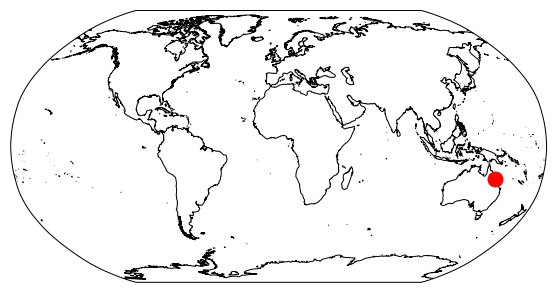

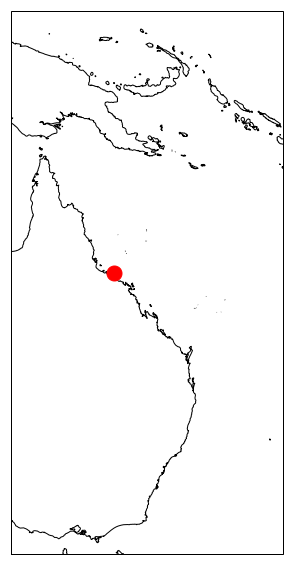

In [577]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax.set_global()
# ax.stock_img()
ax.coastlines('50m')
ax.plot(lon, lat, 'or', transform=ccrs.PlateCarree(),markersize=15)
plt.show()

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([140, 160, -40, 0], crs=ccrs.PlateCarree())
# ax.set_global()
# ax.stock_img()
ax.coastlines('10m')
ax.plot(lon, lat, 'or', transform=ccrs.PlateCarree(),markersize=15)
plt.show()

## depths of data at mooring site

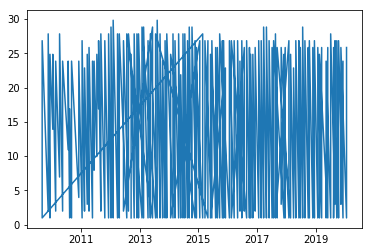

In [578]:
plt.plot(df3[df3['site_code'].str.match(site_code_for_comparison)].datetime,df3[df3['site_code'].str.match(site_code_for_comparison)].DEPTH)


### bottom data from mooring site

Text(0,0.5,'temp ($\\circ$C)')

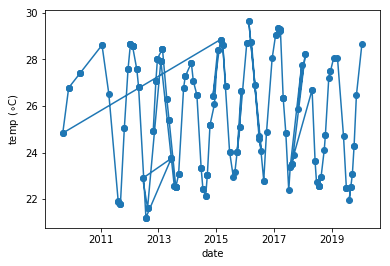

In [579]:
subset = df3[(df3['site_code'].str.match(site_code_for_comparison)) & (df3['DEPTH'] > bottom_depth_greater_than)]
plt.scatter(subset.datetime.values,subset.TEMP.values)
plt.plot(subset.datetime.values,subset.TEMP.values)
plt.xlabel('date')
plt.ylabel('temp ($\circ$C)')



### surface data from mooring site

Text(0,0.5,'temp ($\\circ$C)')

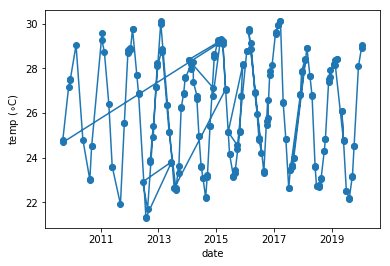

In [580]:
subset = df3[(df3['site_code'].str.match(site_code_for_comparison)) & (df3['DEPTH'] < surface_depth_shallower_than)]
plt.scatter(subset.datetime.values,subset.TEMP.values)
plt.plot(subset.datetime.values,subset.TEMP.values)
plt.xlabel('date')
plt.ylabel('temp ($\circ$C)')

## Model data

In [581]:
def cube_dates_in_datetime(cube):
    return netCDF4.num2date(cube.coord('time').points,cube.coord('time').units.name,cube.coord('time').units.calendar)

In [582]:
def find_nearest_ocean_lat_lon(cube,lat,lon):
#     cube = cube_surface
    places = zip(cube.coord('latitude').points, cube.coord('longitude').points)

    places = []
    cube_data = cube.data
    for i,c_lat in enumerate(cube.coord('latitude').points):
        for j,c_lon in enumerate(cube.coord('longitude').points):
            if cube_data[0,i,j] < 1.0e30:
                places.append([c_lat,c_lon])

    tree = KDTree(places)
    closest = tree.query([lat, lon])
    lat_index = cube.coord('latitude').nearest_neighbour_index(places[closest[1]][0])
    lon_index = cube.coord('longitude').nearest_neighbour_index(places[closest[1]][1])
    return lat_index,lon_index

In [583]:
cube_surface = iris.load_cube('/Users/ph290/Downloads/era5_GBR/era5_GBR_surfacetemperature.nc')
cube_bottom = iris.load_cube('/Users/ph290/Downloads/era5_GBR/era5_GBR_bottomtemperature.nc')

In [584]:
lat_index,lon_index = find_nearest_ocean_lat_lon(cube_surface,lat,lon)

### comparison of mooring location with nearest model point

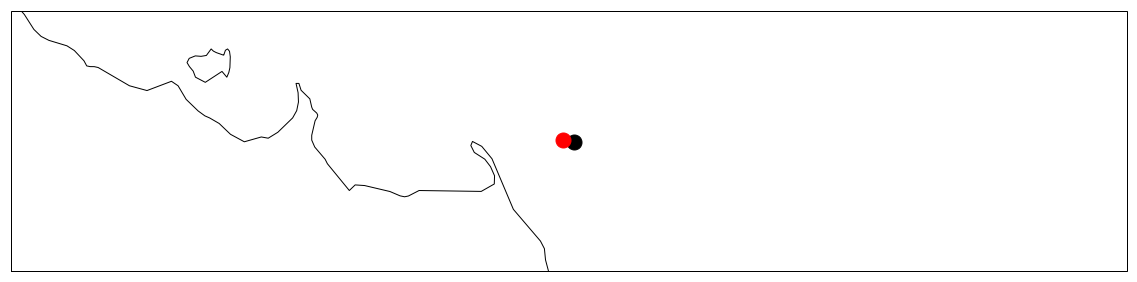

In [585]:
model_lon = cube_surface.coord('longitude').points[lon_index]
model_lat = cube_surface.coord('latitude').points[lat_index]

fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
factor = 50.0
w = min([lon,model_lon])-((max([lon,model_lon]) - min([lon,model_lon]))*factor)
e = max([lon,model_lon])+((max([lon,model_lon]) - min([lon,model_lon]))*factor)
s = min([lat,model_lat])-((max([lat,model_lat]) - min([lat,model_lat]))*factor)
n = max([lat,model_lat])-((min([lat,model_lat]) - max([lat,model_lat]))*factor)

# ax.set_extent([140, 155, -30, -10], crs=ccrs.PlateCarree())
ax.set_extent([w, e, n, s], crs=ccrs.PlateCarree())
# ax.set_global()
# ax.stock_img()
ax.coastlines('10m')
ax.plot(lon, lat, 'ok', transform=ccrs.PlateCarree(),markersize=15)
ax.plot(cube_surface.coord('longitude').points[lon_index], cube_surface.coord('latitude').points[lat_index], 'or', transform=ccrs.PlateCarree(),markersize=15)

plt.show()

## Comparison of surface temperatures with mooring data

In [586]:
plot_data = cube_surface[:,lat_index,lon_index].data
plot_data = np.ma.masked_where(plot_data > 1.0e30,plot_data)

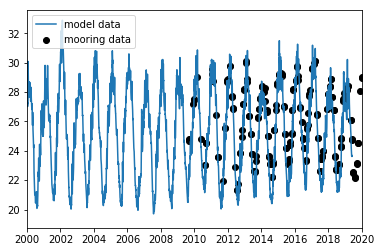

In [587]:
plt.plot(cube_dates_in_datetime(cube_surface),plot_data,label='model data')
subset = df3[(df3['site_code'].str.match(site_code_for_comparison)) & (df3['DEPTH'] < surface_depth_shallower_than)]
plt.scatter(subset.datetime.values,subset.TEMP.values,c='k',label = 'mooring data')
plt.xlim([datetime.date(2000, 1, 1), datetime.date(2020, 1, 1)])
plt.legend(loc=2)
plt.savefig('surface_model_mooring_comparison_'+site_code_for_comparison+'.png')

## Comparison of bottom temperatures with mooring data

In [588]:
plot_data = cube_bottom[:,lat_index,lon_index].data
plot_data = np.ma.masked_where(plot_data > 1.0e30,plot_data)

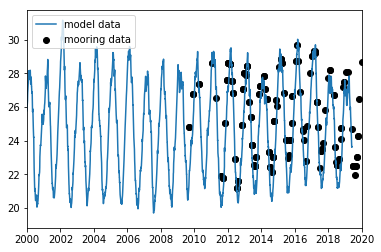

In [589]:
plt.plot(cube_dates_in_datetime(cube_bottom),plot_data,label='model data')
subset = df3[(df3['site_code'].str.match(site_code_for_comparison)) & (df3['DEPTH'] > bottom_depth_greater_than)]
plt.scatter(subset.datetime.values,subset.TEMP.values,c='k',label = 'mooring data')
plt.xlim([datetime.date(2000, 1, 1), datetime.date(2020, 1, 1)])
plt.legend(loc=2)
plt.savefig('bottom_model_mooring_comparison_'+site_code_for_comparison+'.png')